## PROJETO 3 CIÊNCIA DOS DADOS ##

## Classificador de desenhos ##

Autores: **Pedro Luiz da Costa** - 
**Rafael Libertini** - 
**Gabriel Zezze**

**Introdução:** Em nosso projeto exploramos uma base de dados com mais de 50M de arquivos vetoriais representando desenhos em 350 diferentes categorias. Frente ao desafio de criar um classificador para reconhecer desenhos dentro dessas categorias, usamos alguns métodos de machine learning oferecidos pela biblioteca scikit-learn do python.

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from PIL import Image
import os
import time
import subprocess
from sklearn.metrics import accuracy_score
import cv2
from matplotlib.pyplot import figure
import warnings 
warnings.filterwarnings('ignore')

In [6]:
airplane = pd.read_csv('csv/airplane.csv')
octopus = pd.read_csv('csv/octopus.csv')
flower = pd.read_csv('csv/flower.csv')
#Verificando com o que estamos trabalhando
airplane.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane


Para utilizar as imagens no classificador precisa-se de uma lista com todos os pixels de cada imagem. De acordo com o DataFrame, a coluna 'drawing' mostra que o desenho obtido é vetorial, ou seja, foram dadas as cordenadas dos pontos que devem ser 'ligados'. Para obter a lista, primeiro precisamos obter a foto em uma variável e depois ler cada pixel com a intensidade da cor: 0 para preto e 255 pra branco.

In [3]:
#Essa função trata a foto vetorial para ser trabalhada
def convert_to_pd(tabela):
    tabela = tabela[tabela.recognized]
    tabela['drawing'] = tabela['drawing'].apply(json.loads)
    tabela = tabela.drop(['countrycode', 'timestamp','key_id'], axis=1)
    return tabela

In [7]:
airplane = convert_to_pd(airplane)
octopus = convert_to_pd(octopus)
flower = convert_to_pd(flower)

airplane_exemplo = airplane[0:2]
airplane_simp = airplane[:1000]
octopus_simp = octopus[:1000]
flower_simp = flower[:1000]

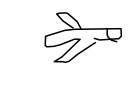

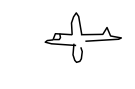

In [19]:
#Plotando os desenhos
for i, drawing in enumerate(airplane_exemplo.drawing[0:2]):
    fig, ax = plt.subplots(figsize=(1.5, 1))
    for x,y in drawing:
        ax.plot(x, -np.array(y),'black')
    ax.axis('off')
    fig.canvas.draw()

In [9]:
#Lendo a foto, convertendo para o array de pixels e salvando em uma coluna do DataFrame
result = []
for i, drawing in enumerate(airplane_exemplo.drawing[0:2]):
    fig, ax = plt.subplots(figsize=(1.5, 1))
    for x,y in drawing:
        ax.plot(x, y,'black')
    ax.axis('off')
    fig.canvas.draw()
    #Conversão do tamanho da foto para pixels
    width, height = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    height = int(height)
    #Como a função retorna 3 valores para cada pixel(RGB), e estamos trabalhando apenas com preto e branco, utilizamos
    #a função reshape para utilizar um valor e otimizar o trabalho.
    image = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    #Concatenando as listas
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).flatten()/255
    plt.close(fig)
    #Transformando o array em uma lista
    gr_img = list(gray_image)
    result.append(gr_img)

airplane_exemplo['array'] = result

airplane_exemplo

,drawing,recognized,word,array
0,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",True,airplane,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",True,airplane,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Para facilitar o trabalho compactamos o exemplo acima em uma função.

In [10]:
def to_array(drawing):
    fig, ax = plt.subplots(figsize=(1.5, 1))
    for x,y in drawing:
        ax.plot(x, y,'black')
    ax.axis('off')
    fig.canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    height = int(height)
    image = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).flatten()/255
    plt.close(fig)
    gr_img = list(gray_image)
    return gr_img

In [11]:
#Convertendo para array
airplane_simp['array'] = airplane_simp['drawing'].apply(to_array)
octopus_simp['array'] = octopus_simp['drawing'].apply(to_array)
flower_simp['array'] = flower_simp['drawing'].apply(to_array)

In [12]:
#Separando o treino do teste e embaralhando o DataFrame
train = pd.concat([airplane_simp[:800],octopus_simp[:800], flower_simp[:800]]).sample(frac=1)
test = pd.concat([airplane_simp[800:1000],octopus_simp[800:1000], octopus_simp[800:1000]]).sample(frac=1)


train['array'] = train['array']
test['array'] = test['array']

X_train = list(train['array'])
y_train = list(train['word'])

X_test = list(test['array'])
y_test = list(test['word'])

## Random Forest ##

O primeiro método avaliado foi o Random Forest, um método baseado em árvores de decisão. Para entendermos como esse método funciona, precisamos entender o conceito de uma árvore de decisão. 

Um bom exemplo para abstrair esse conceito conceito é a previsão da temperatura máxima de amanhã na cidade de São Paulo, dia 15 de Janeiro. Se não soubermos em qual mês estamos, é razoável definir um escopo de estimativas de 15°C a 38°C, sabendo que essas são as mínimas e máximas anuais. Podemos fazer alguma pergunta para melhorar essa estimativa, como por exemplo, “ Em que estação estamos? ”. Se estamos no verão, nosso escopo diminui para 22°C a 38°C. Perguntando, “Qual a temperatura máxima histórica nos dia 15 de Janeiro” (31°C) diminuímos para 27°C a 37°C. Estamos chegando perto, porém, para fazer uma melhor previsão, podemos nos perguntar “Qual foi a temperatura máxima hoje?”, sabendo que hoje a máxima foi de 29°C podemos pensar que o ano foi um pouco mais frio que a média histórica, finalizando nossa predição dizendo que amanhã a máxima será de 30°C.

![image.png](img/image.png)

Poderíamos seguir fazendo infinitas questões, porém, a partir desse ponto, o retorno só irá diminuir, portanto podemos seguir com nossa estimativa atual sem grandes perdas de confiança no resultado e sem desperdiçar esforço. Resumindo o exemplo, para chegar em uma predição fizemos uma série de perguntas, cada uma reduzindo o escopo de possíveis resultados, até chegarmos em um resultado que estávamos confiantes(isso tudo sem gastar esforço desnecessário). Esse processo ainda não é a árvore de decisão, porém, nos auxiliará no seu entendimento. Podemos resumir nossa predição em um gráfico. 

Fizemos nossa predição com base em um modelo mental de pergunta-e-resposta, que nada mais é que uma árvore de decisões simplificada.

As duas principais diferenças entre nosso modelo e a árvore de decisões são, primeiramente, o fato de termos negligenciado a os ramos alternativos, ou seja, a predição que teríamos chegado se a resposta às questões fosse diferente (ex: Se a resposta às estações fosse inverno.) e, por último, uma característica muito diferente é que a árvore de decisões só aceita perguntas de sim e não (True ou False), portanto para a pergunta da temperatura hoje, o método perguntara todas as possíveis temperaturas, e alguma delas terá resposta True, enquanto as outras tem False.

Portanto um diagrama de árvore de decisões bem simplificado ficará parecido com a  figura abaixo:
		
![arvore_decisoes.png](img/image2.png)        
        
Esse diagrama pode parecer muito diferente do nosso modelo mental, porém ele é apenas uma expansão dele. Nosso modelo está contido nessa árvore, basta tomar o caminho mais abaixo e seguir por nossas respostas e chegamos a mesma predição.

O modelo Random Forest, em sua essência, é uma árvore de decisões, que consegue decidir as “perguntas” que  irá fazer, partindo dos dados que colocamos, e assim, montar uma árvore que consiga englobar o máximo de casos para fazer uma previsão coerente.
	Apesar de simples nosso modelo já serve para fazer algumas predições, porém ele não tem nenhum conhecimento prévio do assunto, assim ele não sabe que se Inverno = Mais Frio, ele tem que aprender todas as relações com os dados do problema que jogamos nele. Chegamos agora a parte de Machine Learning, onde vamos treinar nosso Random Forest para que ele possa efetivamente fazer predições. Temos que então separar um pedaço de nossos dados, geralmente 80%, para alimentar o programa. Damos ao Machine Learning todos os dados relevantes ao problema, e dizemos qual o resultado desses dados.
    
Seguindo nosso exemplo da temperatura, precisamos de uma base de dados com informações relevantes para a previsão de tempo (conhecidas como “Features”) e dos valores da temperatura naqueles dias (valor que nós queremos prever “target”). Assim, ele “entenderá” que fatores levam a um específico resultado. Essa é chamada a fase de treino, que deve ser feita antes de qualquer previsão.
   
Com nosso Random Forest treinado, podemos agora usar o que sobrou dos nossos dados como base de Teste. Utilizando os mesmos tipos de variáveis que o modelo treinou, nós damos um cenário para o modelo e ele nos retorna um valor de temperatura, baseado no que ele sabe sobre dias com essas característica. Um exemplo muito simplificado é o de treinarmos com uma base que em janeiro a temperatura é sempre maior que 30 graus, portanto, se nós tentarmos prever a temperatura em um dia de janeiro, ele nos retorna  uma temperatura maior que 30 graus.

Para nosso trabalho utilizamos a biblioteca Scikit Learn do Python, que conta com vários métodos de machine learning. Aplicamos nossas imagens como treino, e como target demos as suas categorias. O random forest nos retorna um modelo treinado, e quando colocamos uma foto nova ele nos retorna a possível categoria de target em que ela pode se encaixar.

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

Acurácia: 0.8066666666666666


## Stochastic Gradient Descent (SGD) ##

Outro método que testamos foi o SGD (“Stochastic gradient descent”), método muito comum no mundo do machine learning, por ser muito eficaz e relativamente simples de ser implementado.

O SGD é um algoritmo de otimização baseado em funções convexas; ele pode minimizar uma função para seu mínimo, a partir de mudanças em seus parâmetros, que o método aplica de maneira iterativa.

Para entendermos melhor o método precisamos definir um importante aspecto utilizado, o gradiente. Ele pode ser entendido como a taxa de variação de uma dada função, ou seja, quanto a saída dessa função mudará, dado um pequeno incremento em sua entrada. Ou seja, quanto maior o gradiente, maior a derivada (taxa de variação) e portanto, o modelo irá aprender mais rapidamente e se o gradiente for zero, o modelo não aprenderá mais. Uma definição matemática do gradiente é a derivada parcial, com respeito a entrada da função.

Podemos imaginar o SGD como alguém vendado tentando subir uma montanha com menor número de  passos possíveis. No começo ele dará largos passos na parte mais inclinada da montanha, porém ao chegar perto do topo, ele diminui seus passos, para não arriscar passar o cume. Esse processo pode ser descrito a partir de um gradiente.

Se visualizarmos a figura abaixo, como uma vista superior da montanha, com as linhas representando uma mudança de altitude (curva de nível). As setas vermelhas representam os passos do nosso homem hipotético. A partir da imagem podemos abstrair o gradiente como um vetor, que indica a direção do passo na direção mais íngreme.

![exemplo_sgd.png](img/image3.png)  

Podemos notar que o gradiente de X0 a X1 é muito mais longo que o de X3 a X4, isso ocorre pois a colina fica menos íngreme conforme nosso amigo sobe a montanha. Isso se relaciona com a taxa de variação diminuindo em um função convexa, conforme chegamos em seu máximo (“cume da montanha”), a taxa de variação diminui.

O SGD pode ser programado também para chegar no fundo de um vale, ou o mínimo de uma função. O que queremos, basicamente, é chegar lá o mais rápido possível, sem correr o risco de passar reto e ter que fazer meia volta. O caminho que tomamos até chegar ao nosso mínimo ou máximo é chamado de taxa de aprendizagem, e pode ser resumido em duas imagens:

![exemplo_sgd.png](img/image4.png)  

Na imagem vemos os dois extremos da taxa de aprendizagem, uma taxa alta, nos dá um caminho errado, onde passamos muitas vezes do objetivo e temos que dar meia volta, pois tomamos passos muito grandes, a segunda nos mostra uma abordagem muito conservadora, onde, para não correr o risco de não errar, tomamos passos muito pequenos, e acabamos demorando uma eternidade para chegar ao destino. Nosso trabalho é otimizar essa taxa de modo a chegar rápida e eficientemente a nosso mínimo. Se plantarmos diferentes taxas de aprendizado podemos padronizar o que seria uma taxa boa ou ruim:

![exemplo_sgd.png](img/image5.png)  

A esquerda temos a taxa ideal, onde sempre diminuirmos nossa função até chegarmos no mínimo absoluto, e a direita alguns exemplos de taxas incorretas, onde a função sempre cresce ou estabiliza num valor maior que o mínimo real.

Entender melhor as técnicas de machine learning nos fez refletir sobre como melhorar a performance de nosso classificador, permitindo-nos obter um resultado mais próximo da realidade.


In [1]:
from sklearn.linear_model import SGDClassifier
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

sgd_clf = SGDClassifier(max_iter=5, tol=None, random_state=RANDOM_SEED) 
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

NameError: name 'np' is not defined

## Conclusão 


Nosso modelo foi treinado usando dois métodos de machine learning, e ambos tiveram acurácias parecidas, conseguindo prever qual categoria se encaixa um desenho. 
De início estávamos usando na casa de 20 mil fotos para o treino, porém, após a aproximação do código, obtivemos um excelente resultado, usando mil fotos por categoria. 
Uma possível aplicação para nosso projeto é um sistema de reconhecimento de assinaturas. Se tivermos uma base de dados com assinaturas, podemos tratá-las como tratamos nossos desenhos, treinando com a base de dados, e testando com uma nova assinatura. Isso pode ser aplicado em uma farmácia on-line por exemplo, onde o site pode verificar a assinatura de médicos.
